In [1]:
# This notebook contains code for evaluating iterative pruned model on CIFAR dataset.
# We are using following evaluation metrices
# sparisty = zero parameters/parameter
# Test Accuracy = Correctly classified data poimts from test data/total amount of data points from test data
# Accuracy Drop = test accuracy without pruning - test accuracy after pruning 
# Inference time = averaged time spent on the inference of one image
# Speedup = inference time  before pruninginfrence time  after pruning

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
FOLDERNAME = 'cs532/project_2_cnn_pruning/'
%cd drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs532/project_2_cnn_pruning


In [3]:
# Dataset Preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import time
from torchvision import datasets, transforms
import requests
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
import random
from sklearn.metrics import confusion_matrix
import os
import datetime

In [4]:
torch.cuda.empty_cache()

In [5]:
# If GPU is available, use it
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
best_acc = 0
start_epoch = 0

In [7]:
# Data augmentation and normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)),
])

In [8]:
testset = torchvision.datasets.CIFAR10(
root='./data',train=False,download=True,transform=transform_test)

Files already downloaded and verified


In [9]:
testloader = torch.utils.data.DataLoader(testset,batch_size=100,shuffle=False,num_workers=2)

In [10]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [11]:
# Load the pretrained model
from cifar10_models.resnet import resnet18
my_model = resnet18()

# Pretrained model
my_model = resnet18(pretrained=True)
my_model.to(device)
my_model.eval()
epoch= 1
criterion = nn.CrossEntropyLoss()

In [12]:
# Evaluation Script
def test(epochs,model):
    val_acc=0
    val_loss=0
    val_correct=0
    val_total = 0
    with torch.no_grad():
        for batch_idx, (inputs,targets) in enumerate(testloader):
            inputs,targets = inputs.to(device),targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            val_loss += loss.item()
            _,predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
            val_acc = 100.*val_correct/val_total
            if batch_idx%40==39:
                print("Evaluating....")
                print(batch_idx,len(testloader),'Loss: %.3f | Acc: %0.3f (%d/%d)' % (val_loss/(batch_idx+1),100*val_correct/val_total,val_correct,val_total))
    return val_acc
    


In [13]:
validation_accuracy =  test(1,my_model)

Evaluating....
39 100 Loss: 0.283 | Acc: 92.125 (3685/4000)
Evaluating....
79 100 Loss: 0.276 | Acc: 92.475 (7398/8000)


In [14]:
def load_model(model_name):
    script_dir = os.path.abspath(os.getcwd())
    model = torch.load(
        script_dir + "/cifar10_models/state_dicts/" + model_name + ".pt", map_location=device
    )
    return model

In [15]:
def calculate_sparsity(model):
  total_count = 0
  zero_count = 0
  
  for buffer_name, buffer in model.named_buffers():
    zero_count += torch.sum(buffer == 0).item()
    if zero_count>0:
      total_count += buffer.nelement()

  print("Total params: ", total_count)
  print("Zero params: ", zero_count)
  return (math.ceil(zero_count*100/total_count))

In [16]:
# EValuation for one image
def test_inference(epochs,model):
    val_acc=0
    val_loss=0
    val_correct=0
    val_total = 0
    with torch.no_grad():
        for batch_idx, (inputs,targets) in enumerate(testloader):
            if batch_idx>1:
                break
            inputs,targets = inputs.to(device),targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,targets)
            val_loss += loss.item()
            _,predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
            val_acc = 100.*val_correct/val_total
            if batch_idx%40==39:
                print("Evaluating....")
                print(batch_idx,len(testloader),'Loss: %.3f | Acc: %0.3f (%d/%d)' % (val_loss/(batch_idx+1),100*val_correct/val_total,val_correct,val_total))
    return val_acc

In [23]:
# Inference time for unprunned mode
start_time = datetime.datetime.now()
test_inference(1,my_model)

end_time = datetime.datetime.now()


time_diff = (end_time - start_time)

inference_time_uprunned_model = (time_diff.total_seconds()+1) * 1000

In [22]:
# Evaluating iterative prunned model with 50 percent sparcity_ratio
resnet_iterative_prunned_50 = load_model("iterative_50")

resnet_iterative_prunned_50.to(device)
resnet_iterative_prunned_50.eval()
epoch= 1
criterion = nn.CrossEntropyLoss()
validation_accuracy_50 = test(1,resnet_iterative_prunned_50)
accuracy_drop_50 = validation_accuracy-validation_accuracy_50


Evaluating....
39 100 Loss: 0.281 | Acc: 92.125 (3685/4000)
Evaluating....
79 100 Loss: 0.274 | Acc: 92.450 (7396/8000)


In [44]:
# Calculating various inference params for 50 percent prunned model
start_time = datetime.datetime.now()
test_inference(1,resnet_iterative_prunned_50)

end_time = datetime.datetime.now()


time_diff = (end_time - start_time)

In [46]:


inference_time_prunned_50 = time_diff.total_seconds() * 1000
speedup_prunned_50 = inference_time_uprunned_model/inference_time_prunned_50
print("++++++++++++++++++++++++++++++++++++++")
print("Various Evaluation metrics for the iterative_prunned_50 model")
print(f"Sparsity: {0.5*100} percent")
print(f"Test Accuracy: {validation_accuracy_50:.2f}")
print(f"Accuracy Drop {accuracy_drop_50:.2f}")
print(f"Inference time unprunned model {inference_time_uprunned_model:.2f}")
print(f"Inference time {inference_time_prunned_50:.2f}")
print(f"Speed up {speedup_prunned_50:.2f}")
sparsity_50 = calculate_sparsity(resnet_iterative_prunned_50)
print(f"Sparsity : {sparsity_50}")
print("++++++++++++++++++++++++++++++++++++++++")

++++++++++++++++++++++++++++++++++++++
Various Evaluation metrics for the iterative_prunned_50 model
Sparsity: 50.0 percent
Test Accuracy: 92.55
Accuracy Drop 0.04
Inference time unprunned model 2679.88
Inference time 1882.50
Speed up 1.42
Total params:  11173972
Zero params:  5535550
Sparsity : 50
++++++++++++++++++++++++++++++++++++++++


In [21]:
# Evaluating iterative prunned model with 75 percent sparcity_ratio
resnet_iterative_prunned_75 = load_model("iterative_75")

resnet_iterative_prunned_75.to(device)
resnet_iterative_prunned_75.eval()
epoch= 1
criterion = nn.CrossEntropyLoss()
validation_accuracy_75 = test(1,resnet_iterative_prunned_75)

Evaluating....
39 100 Loss: 0.451 | Acc: 87.700 (3508/4000)
Evaluating....
79 100 Loss: 0.431 | Acc: 88.088 (7047/8000)


In [25]:
# Calculating various inference params for 75 percent prunned model
start_time = datetime.datetime.now()
test_inference(1,resnet_iterative_prunned_75)

end_time = datetime.datetime.now()


time_diff = (end_time - start_time)

In [26]:
inference_time_prunned_75 = time_diff.total_seconds() * 1000
speedup_prunned_75 = inference_time_uprunned_model/inference_time_prunned_75
accuracy_drop_75 = validation_accuracy-validation_accuracy_75
print("++++++++++++++++++++++++++++++++++++++")
print("Various Evaluation metrics for the iterative_prunned_75 model")
print(f"Sparsity: {0.5*100} percent")
print(f"Test Accuracy: {validation_accuracy_75:.2f}")
print(f"Accuracy Drop {accuracy_drop_75:.2f}")
print(f"Inference time unprunned model {inference_time_uprunned_model:.2f}")
print(f"Inference time {inference_time_prunned_75:.2f}")
print(f"Speed up {speedup_prunned_75:.2f}")
calculate_sparsity(resnet_iterative_prunned_75)
sparsity_75 = calculate_sparsity(resnet_iterative_prunned_75)
print(f"Sparsity : {sparsity_75}")
print("++++++++++++++++++++++++++++++++++++++++")

++++++++++++++++++++++++++++++++++++++
Various Evaluation metrics for the iterative_prunned_75 model
Sparsity: 50.0 percent
Test Accuracy: 87.97
Accuracy Drop 4.62
Inference time unprunned model 2679.88
Inference time 1761.02
Speed up 1.52
Total params:  11173972
Zero params:  8333602
Total params:  11173972
Zero params:  8333602
Sparsity : 75
++++++++++++++++++++++++++++++++++++++++


In [27]:
# Evaluating iterative prunned model with 90 percent sparcity_ratio
resnet_iterative_prunned_90 = load_model("iterative_90")

resnet_iterative_prunned_90.to(device)
resnet_iterative_prunned_90.eval()
epoch= 1
criterion = nn.CrossEntropyLoss()
validation_accuracy_90 = test(1,resnet_iterative_prunned_90)
accuracy_drop_90 = validation_accuracy-validation_accuracy_90

Evaluating....
39 100 Loss: 0.423 | Acc: 87.325 (3493/4000)
Evaluating....
79 100 Loss: 0.415 | Acc: 87.800 (7024/8000)


In [34]:
# Calculating various inference params for 90 percent prunned model
start_time = datetime.datetime.now()
test_inference(1,resnet_iterative_prunned_90)

end_time = datetime.datetime.now()


time_diff = (end_time - start_time)

inference_time_prunned_90 = time_diff.total_seconds() * 1000

In [40]:

speedup_prunned_90 = inference_time_uprunned_model/inference_time_prunned_90
print("++++++++++++++++++++++++++++++++++++++")
print("Various Evaluation metrics for the iterative_prunned_90 model")
print(f"Sparsity: {0.5*100} percent")
print(f"Test Accuracy: {validation_accuracy_90:.2f}")
print(f"Accuracy Drop {accuracy_drop_90:.2f}")
print(f"Inference time unprunned model {inference_time_uprunned_model:.2f}")
print(f"Inference time {inference_time_prunned_90:.2f}")
print(f"Speed up {speedup_prunned_90:.2f}")
calculate_sparsity(resnet_iterative_prunned_90)
sparsity_90 = calculate_sparsity(resnet_iterative_prunned_90)
print(f"Sparsity {sparsity_90}")
print("++++++++++++++++++++++++++++++++++++++++")

++++++++++++++++++++++++++++++++++++++
Various Evaluation metrics for the iterative_prunned_90 model
Sparsity: 50.0 percent
Test Accuracy: 87.91
Accuracy Drop 4.68
Inference time unprunned model 2679.88
Inference time 1732.05
Speed up 1.55
Total params:  11173972
Zero params:  9965588
Total params:  11173972
Zero params:  9965588
Sparsity 90
++++++++++++++++++++++++++++++++++++++++


No handles with labels found to put in legend.


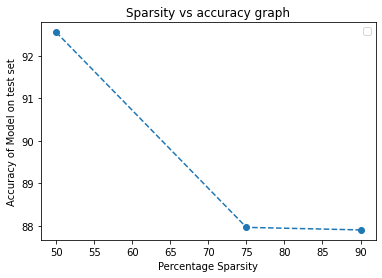

In [41]:
# Sparsity vs accuracy graph

# line 1 points
sparsity = [sparsity_50,sparsity_75,sparsity_90]
accuracy = [validation_accuracy_50,validation_accuracy_75,validation_accuracy_90]
# plotting the line 1 points 
plt.xlabel('Percentage Sparsity')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy of Model on test set')
# Set a title of the current axes.
plt.title('Sparsity vs accuracy graph')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.plot(sparsity, accuracy, linestyle='--', marker='o')
plt.show()

No handles with labels found to put in legend.


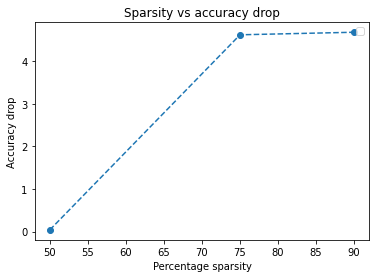

In [42]:
# sparsity vs accuracy drop graph
# line 1 points
sparsity = [sparsity_50,sparsity_75,sparsity_90]
accuracy_drop = [accuracy_drop_50,accuracy_drop_75,accuracy_drop_90]
# plotting the line 1 points 
plt.xlabel('Percentage sparsity')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy drop')
# Set a title of the current axes.
plt.title('Sparsity vs accuracy drop')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.plot(sparsity, accuracy_drop, linestyle='--', marker='o')
plt.show()

No handles with labels found to put in legend.


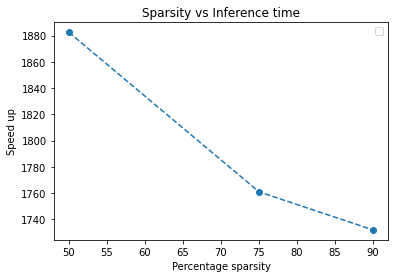

In [47]:
# sparsity vs Inference time graph (Bonus)
# line 1 points
sparsity = [sparsity_50,sparsity_75,sparsity_90]
inference_time = [inference_time_prunned_50,inference_time_prunned_75,inference_time_prunned_90]
# plotting the line 1 points 
plt.xlabel('Percentage sparsity')
# Set the y axis label of the current axis.
plt.ylabel('Speed up')
# Set a title of the current axes.
plt.title('Sparsity vs Inference time')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.plot(sparsity, inference_time, linestyle='--', marker='o')
plt.show()

No handles with labels found to put in legend.


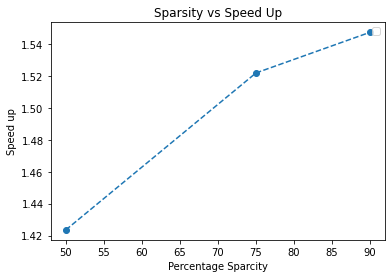

In [48]:
# Sparsity vs speed up graph (Bonus)
# line 1 points
sparsity = [sparsity_50,sparsity_75,sparsity_90]
speedup = [speedup_prunned_50,speedup_prunned_75,speedup_prunned_90]
# plotting the line 1 points 
plt.xlabel('Percentage Sparcity')
# Set the y axis label of the current axis.
plt.ylabel('Speed up')
# Set a title of the current axes.
plt.title('Sparsity vs Speed Up')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.plot(sparsity, speedup, linestyle='--', marker='o')
plt.show()